# Filtering and smoothing for the simple pendulum

In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt

from stoch_ham.base import MVNStandard, FunctionalModel
from stoch_ham.filtering import filtering
from stoch_ham.smoothing import smoothing
from stoch_ham.linearization import extended
from stoch_ham.simple_pendulum.data import get_dataset, hamiltonian

## Get the data

In [2]:
seed = 5
key = random.PRNGKey(seed)

meas_error = jnp.array([.5, 2.5])

true_params = {
    'mass': 1.,
    'length': 2.,
    'lambda': 5.,
    'q': 0.5
}

sim_dt = 0.001
sampling_rate = 10
dt = 1./sampling_rate

x0_mean = jnp.array([jnp.pi / 2, 0.])
t_span = (0., 10.)

true_traj, observations = get_dataset(
    key, 1, true_params, x0_mean, t_span, meas_error, sim_dt, sampling_rate)[0]

ts = jnp.linspace(*t_span, len(observations))

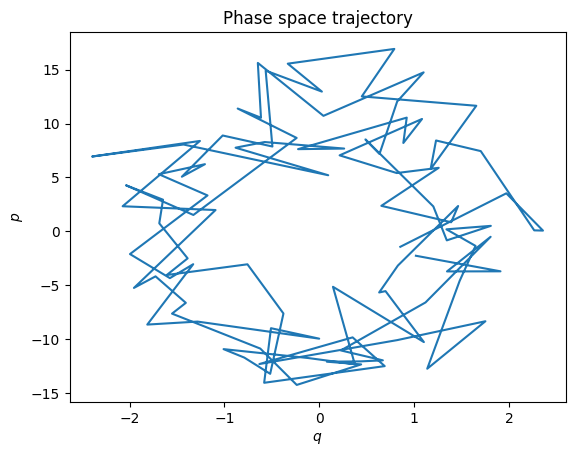

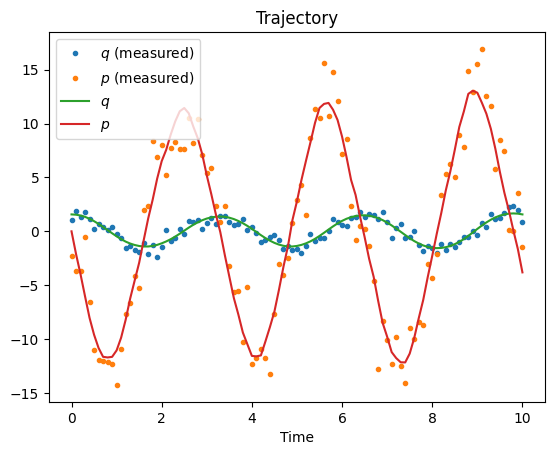

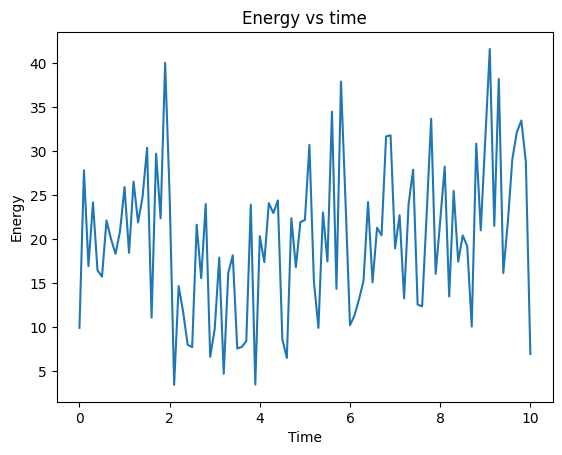

In [3]:
plt.figure()
plt.plot(observations[:, 0], observations[:, 1])
plt.xlabel(r"$q$")
plt.ylabel(r"$p$")
plt.title("Phase space trajectory")
plt.show()

plt.figure()
plt.plot(ts, observations[:, 0], '.', label=r"$q$ (measured)")
plt.plot(ts, observations[:, 1], '.', label=r"$p$ (measured)")
plt.plot(ts, true_traj[:, 0], label=r"$q$")
plt.plot(ts, true_traj[:, 1], label=r"$p$")
plt.title("Trajectory")
plt.xlabel("Time")
plt.legend()
plt.show()

energies = jax.vmap(hamiltonian, in_axes=(0, None))(observations, true_params)
plt.figure()
plt.plot(ts, energies)
plt.title("Energy vs time")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.show()

## Filtering and smoothing

In [4]:
def drift_fun(x, params):
    """
    The drift function of the augmented state.
    """
    q, p, u = x
    g = 9.81
    m, l, lamba = params['mass'], params['length'], params['lambda']
    return jnp.array([p / (m * l ** 2), -m * g * l * jnp.sin(q) - u, -lamba * u])


def get_Q(params, dt):
    """
    Get the process noise covariance matrix `Q`
    by first defining the diffusion vector `L`.
    """
    L = jnp.array([0., 0., 1.])[:, None]
    return L @ L.T * params['q'] * dt


def get_x0(params):
    """
    Define the distribution of the initial state.
    """
    x0mean = jnp.array([jnp.pi / 2, 0., 0.])
    u0_cov = params['q'] / (2 * params['lambda'])
    x0cov = jnp.diag(jnp.array([1., 1., u0_cov]))
    x0 = MVNStandard(x0mean, x0cov)
    return x0


def get_ell_and_filter(params, observations, dt, meas_error):
    """
    Wrapper function to get the marginal data log-likelihood
    and the filtered states.
    """
    # Define the transition model.
    Q = get_Q(params, dt)
    transition_model = FunctionalModel(
        lambda x: x + drift_fun(x, params) * dt,
        MVNStandard(jnp.zeros(3), Q)
    )

    # Define the observation model.
    R = jnp.diag(meas_error)
    H = jnp.array([[1., 0., 0.], [0., 1., 0.]])
    observation_model = FunctionalModel(
        lambda x: H @ x,
        MVNStandard(jnp.zeros(2), R)
    )

    # Get the initial state distribution and run the filter.
    x0 = get_x0(params)
    filt_states, ell = filtering(observations, x0, transition_model, observation_model, extended)
    # Run the smoother.
    smoothed_states = smoothing(transition_model, filt_states, extended)
    return ell, filt_states, smoothed_states

The log marginal likelihood of the data is -461.9893493652344


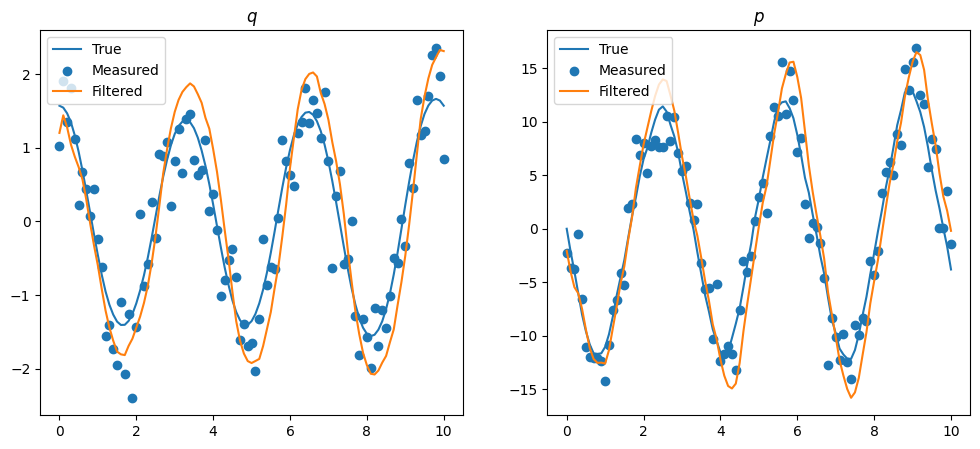

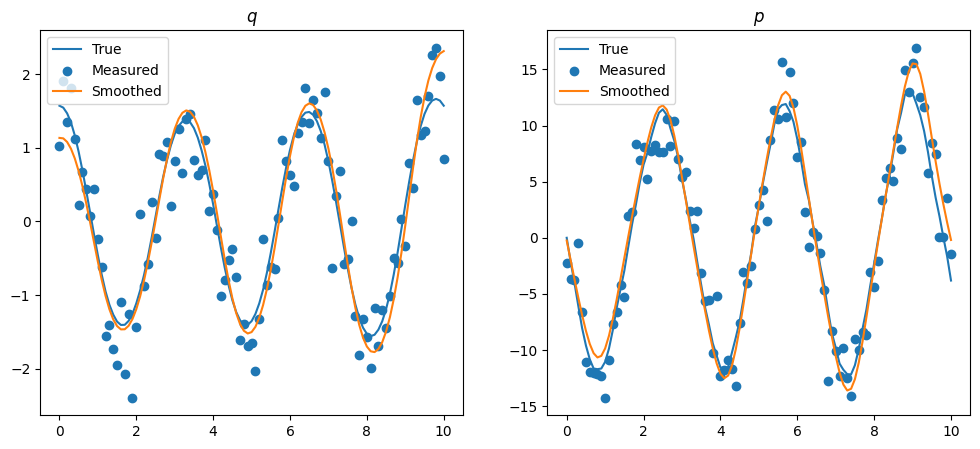

In [5]:
params = {
    'mass': 1.,
    'length': 2.,
    'lambda': 2.,
    'q': 2.
}

nll, filt_states, smoothed_states = get_ell_and_filter(params, observations, dt, meas_error)
print(f"The log marginal likelihood of the data is {nll}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(ts, true_traj[:, 0], label="True")
ax1.scatter(ts, observations[:, 0], label="Measured")
ax1.plot(ts, filt_states.mean[1:, 0], label="Filtered")
ax1.set_title(r"$q$")
ax1.legend()

ax2.plot(ts, true_traj[:, 1], label="True")
ax2.scatter(ts, observations[:, 1], label="Measured")
ax2.plot(ts, filt_states.mean[1:, 1], label="Filtered")
ax2.set_title(r"$p$")
ax2.legend()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(ts, true_traj[:, 0], label="True")
ax1.scatter(ts, observations[:, 0], label="Measured")
ax1.plot(ts, smoothed_states.mean[1:, 0], label="Smoothed")
ax1.set_title(r"$q$")
ax1.legend()

ax2.plot(ts, true_traj[:, 1], label="True")
ax2.scatter(ts, observations[:, 1], label="Measured")
ax2.plot(ts, smoothed_states.mean[1:, 1], label="Smoothed")
ax2.set_title(r"$p$")
ax2.legend()